## 타이타닉 생존자 예측
https://www.kaggle.com/c/2019-1st-ml-month-with-kakr/data

### Plan A
- supervised learning
- decision tree, random forest, XG boost
- classification (0, 1)

### Plan B
- supervised learning
- multi layer regression
- classification (0, 1)


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

tf.enable_eager_execution()

1.13.1
2.2.4-tf


In [2]:
data = pd.read_csv('./train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- survival - 생존유무, target 값. (0 = 사망, 1 = 생존)
- pclass - 티켓 클래스. (1 = 1st, 2 = 2nd, 3 = 3rd)
- sex - 성별
- Age - 나이(세)
- sibsp - 함께 탑승한 형제자매, 배우자 수 총합
- parch - 함께 탑승한 부모, 자녀 수 총합
- ticket - 티켓 넘버
- fare - 탑승 요금
- cabin - 객실 넘버
- embarked - 탑승 항구

In [3]:
data2 = pd.read_csv('./test.csv')

In [4]:
data = data.append(data2, ignore_index=True)
data.tail()

C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\pandas\core\frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668


In [5]:
round(data.describe(), 3)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000,1308.000,1309.000,1309.00,1309.000,1309.000,891.000
mean,29.881,33.295,0.385,655.00,2.295,0.499,0.384
std,14.413,51.759,0.866,378.02,0.838,1.042,0.487
min,0.170,0.000,0.000,1.00,1.000,0.000,0.000
25%,21.000,7.896,0.000,328.00,2.000,0.000,0.000
50%,28.000,14.454,0.000,655.00,3.000,0.000,0.000
75%,39.000,31.275,0.000,982.00,3.000,1.000,1.000
max,80.000,512.329,9.000,1309.00,3.000,8.000,1.000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### 전처리 1: age, cabin, embarked에 null 값 존재 -> 결측치 제거, name drop
- Cabin은 결측치가 너무 많으므로 아예 drop
- Embarked, Age는 mean과 median 두 경우로 결측치 대체해볼 것. (데이터가 891개밖에 안되어 행 제거하면 안될듯..): copy, copy2

### 1-a. Copy (Age: NaN <- mean)

In [154]:
data_copy = data.copy()
data_copy = data_copy.drop('Cabin', axis=1).drop('Name', axis=1)
data_copy.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,S,7.2500,0,1,3,male,1,0.0,A/5 21171
1,38.0,C,71.2833,0,2,1,female,1,1.0,PC 17599
2,26.0,S,7.9250,0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,S,53.1000,0,4,1,female,1,1.0,113803
4,35.0,S,8.0500,0,5,3,male,0,0.0,373450


In [155]:
data_copy.Age

0       22.0
1       38.0
2       26.0
3       35.0
4       35.0
        ... 
1304     NaN
1305    39.0
1306    38.5
1307     NaN
1308     NaN
Name: Age, Length: 1309, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x21b21a6ce10>,
 'caps': [<matplotlib.lines.Line2D at 0x21b21a834e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x21b21a6ccc0>],
 'medians': [<matplotlib.lines.Line2D at 0x21b21a83b70>],
 'fliers': [<matplotlib.lines.Line2D at 0x21b21a83eb8>],
 'means': []}

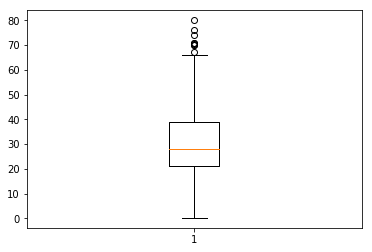

In [156]:
plt.boxplot(data_copy.Age[np.isnan(data_copy.Age) == False])

In [157]:
np.isnan(data_copy.Age)

0       False
1       False
2       False
3       False
4       False
        ...  
1304     True
1305    False
1306    False
1307     True
1308     True
Name: Age, Length: 1309, dtype: bool

In [158]:
data_copy.Age[np.isnan(data_copy.Age) == True] = np.mean(data_copy.Age)
data_copy.Age.describe()

count    1309.000000
mean       29.881138
std        12.883193
min         0.170000
25%        22.000000
50%        29.881138
75%        35.000000
max        80.000000
Name: Age, dtype: float64

### 1-b. Copy2 (Age: NaN <- median)

In [159]:
data_copy2 = data.copy()
data_copy2 = data_copy2.drop('Cabin', axis=1)

In [160]:
np.isnan(data_copy2.Age == True)

0       False
1       False
2       False
3       False
4       False
        ...  
1304    False
1305    False
1306    False
1307    False
1308    False
Name: Age, Length: 1309, dtype: bool

In [161]:
np.median(data_copy2.Age)

nan

In [162]:
np.median(data_copy2.Age[np.isnan(data_copy2.Age) == False])

28.0

In [163]:
data_copy2.Age[np.isnan(data_copy2.Age) == True] = np.median(data_copy2.Age[np.isnan(data_copy2.Age) == False])
data_copy2.Age.describe()

count    1309.000000
mean       29.503186
std        12.905241
min         0.170000
25%        22.000000
50%        28.000000
75%        35.000000
max        80.000000
Name: Age, dtype: float64

### 전처리2

In [164]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
Age            1309 non-null float64
Embarked       1307 non-null object
Fare           1308 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(3)
memory usage: 102.4+ KB


In [165]:
# Sex -> int
data_copy.Sex.value_counts()

male      843
female    466
Name: Sex, dtype: int64

In [166]:
data_copy.Sex.replace({'female':0, 'male':1}, inplace=True)
data_copy.Sex.value_counts()

1    843
0    466
Name: Sex, dtype: int64

In [167]:
# embarked -> int
data_copy.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [21]:
#data_copy.Embarked.replace({'S':0, 'C':1, "Q":2}, inplace=True)
#data_copy.Embarked.value_counts()

0.0    914
1.0    270
2.0    123
Name: Embarked, dtype: int64

In [149]:
# 이렇게 넣으면 순위가 생겨서 안됨!!!

In [150]:
# 더미변수로 만들어 줘야 한다.

In [171]:
pd.get_dummies(data_copy.Embarked)

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
5,0,1,0
6,0,0,1
7,0,0,1
8,0,0,1
9,1,0,0


In [ ]:
pd.get_dummies(data_copy.Embarked)

In [22]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
Age            1309 non-null float64
Embarked       1307 non-null float64
Fare           1308 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(4), int64(5), object(1)
memory usage: 102.4+ KB


In [23]:
data_copy.Embarked.describe()

count    1307.000000
mean        0.394797
std         0.653817
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Embarked, dtype: float64

In [169]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
Age            1309 non-null float64
Embarked       1307 non-null object
Fare           1308 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(5), object(2)
memory usage: 102.4+ KB


In [24]:
data_copy.Embarked[np.isnan(data_copy.Embarked) == True] = 0

C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
data_copy.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [26]:
data_copy.Fare[np.isnan(data_copy.Fare) == True] = np.mean(data_copy.Fare)

C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
Age            1309 non-null float64
Embarked       1309 non-null float64
Fare           1309 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(4), int64(5), object(1)
memory usage: 102.4+ KB


- ticket은 어떻게 할지..?

- cluster learning?

- 일단 배제하고 분석

In [28]:
data_copy.Ticket.value_counts()

CA. 2343        11
1601             8
CA 2144          8
PC 17608         7
S.O.C. 14879     7
                ..
370375           1
694              1
4135             1
32302            1
3410             1
Name: Ticket, Length: 929, dtype: int64

In [29]:
data_copy.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021B1D3ABFD0>,
      dtype=object)

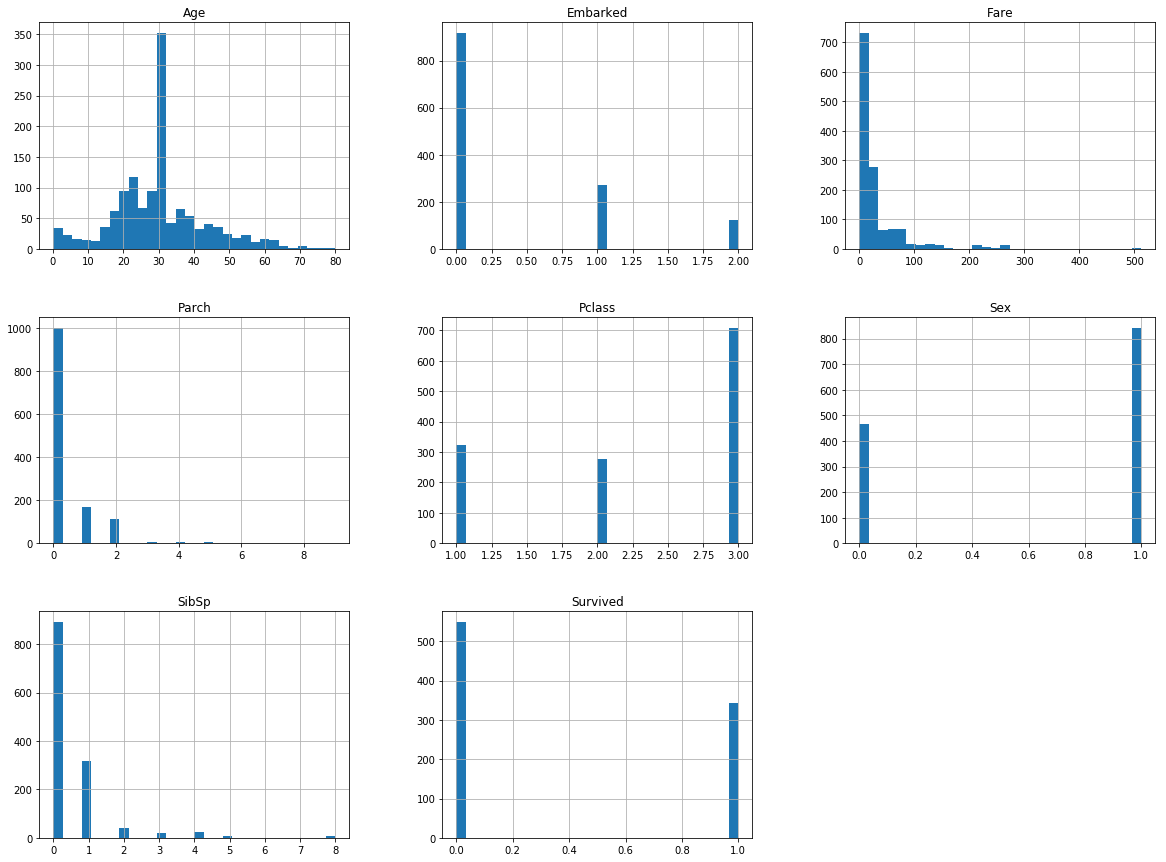

In [30]:
data_copy.hist(bins=30, figsize=(20, 15))

In [31]:
corr_train = data_copy.corr()
round(corr_train['Survived'].sort_values(ascending=True), 3)

Sex        -0.543
Pclass     -0.338
Age        -0.070
SibSp      -0.035
Parch       0.082
Embarked    0.107
Fare        0.257
Survived    1.000
Name: Survived, dtype: float64

In [32]:
data_copy[(data_copy.Survived == 0) | (data_copy.Survived == 1)].shape

(891, 8)

In [33]:
train = data_copy[(data_copy.Survived == 0) | (data_copy.Survived == 1)]

In [34]:
data_copy[-(data_copy.Survived == 0) & -(data_copy.Survived == 1)].shape

(418, 8)

In [35]:
test = data_copy[-(data_copy.Survived == 0) & -(data_copy.Survived == 1)]

# decision tree classification

In [36]:
# 모델 성능 평가 패키지
from sklearn.metrics import classification_report, confusion_matrix

# data set을 training set / test set 분리 서브 패키지
from sklearn.model_selection import train_test_split

# 의사결정트리 알고리즘 서브 패키지
import sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# IPython 내 정보 보여주는 API, raw 데이터가 있는 png jpeg 이미지 객체 만드는 모듈
from IPython.display import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import warnings   # warning 메세지 안 보이게 하려고

# Operating System과 상호작용하기 위한 기본적 기능(경로 생성, 변경)이 제공되는 모듈
import os

In [37]:
X_features = train.iloc[:, :-1]

In [38]:
y_target = train.iloc[:, -1]

In [39]:
y_target.value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                     test_size=0.3, stratify=y_target)

In [41]:
X_train

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp
163,17.000000,0.0,8.6625,0,3,1,0
2,26.000000,0.0,7.9250,0,3,0,0
182,9.000000,0.0,31.3875,2,3,1,4
402,21.000000,0.0,9.8250,0,3,0,1
800,34.000000,0.0,13.0000,0,2,1,0
480,9.000000,0.0,46.9000,2,3,1,5
647,56.000000,1.0,35.5000,0,1,1,0
370,25.000000,1.0,55.4417,0,1,1,1
631,51.000000,0.0,7.0542,0,3,1,0
661,40.000000,1.0,7.2250,0,3,1,0


In [42]:
X_test

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp
119,2.000000,0.0,31.2750,2,3,0,4
174,56.000000,1.0,30.6958,0,1,1,0
683,14.000000,0.0,46.9000,2,3,1,5
747,30.000000,0.0,13.0000,0,2,0,0
811,39.000000,0.0,24.1500,0,3,1,0
560,29.881138,2.0,7.7500,0,3,1,0
86,16.000000,0.0,34.3750,3,3,1,1
423,28.000000,0.0,14.4000,1,3,0,1
454,29.881138,0.0,8.0500,0,3,1,0
46,29.881138,2.0,15.5000,0,3,1,1


In [43]:
y_train

163    0.0
2      1.0
182    0.0
402    0.0
800    0.0
      ... 
130    0.0
653    1.0
233    1.0
862    1.0
744    1.0
Name: Survived, Length: 623, dtype: float64

In [44]:
dt_clf = DecisionTreeClassifier()
dt_clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [45]:
np.array([["TN   FP"], ["FN   TP"]])

array([['TN   FP'],
       ['FN   TP']], dtype='<U7')

In [46]:
dt_clf = dt_clf.fit(X_train, y_train)
dt_prediction = dt_clf.predict(X_test)
print(confusion_matrix(y_test, dt_prediction))

[[136  29]
 [ 31  72]]


In [47]:
# metrics: 업무 수행 결과를 보여주는 계량적 분석

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, dt_prediction)
precision = precision_score(y_test, dt_prediction)
recall = recall_score(y_test, dt_prediction)
f1 = f1_score(y_test, dt_prediction)
roc_auc = roc_auc_score(y_test, dt_prediction)
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
      .format(accuracy, precision, recall, f1, roc_auc))

accuracy: 0.7761, precision: 0.7129, recall: 0.6990, F1: 0.7059, AUC: 0.7616


# random forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                     test_size=0.3, stratify=y_target)

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('rf accuracy: {0:.4f}'.format(accuracy))

rf accuracy: 0.8134


In [49]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.7978


In [50]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=8,
                                 min_samples_split=8, random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.8396


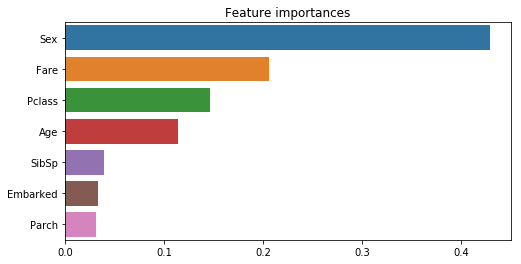

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 4))
plt.title('Feature importances')
sns.barplot(x=ftr, y=ftr.index)
plt.show()

# XG boost

In [52]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [53]:
params = {'random_state':156,
          'early_stoppings':100,
          'objective':'binary:logistic'
         }
num_rounds=400

In [54]:
wlist = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds, evals = wlist)

[0]	train-error:0.139647	eval-error:0.141791
[1]	train-error:0.126806	eval-error:0.149254
[2]	train-error:0.131621	eval-error:0.145522
[3]	train-error:0.123596	eval-error:0.13806
[4]	train-error:0.120385	eval-error:0.134328
[5]	train-error:0.11557	eval-error:0.130597
[6]	train-error:0.11557	eval-error:0.130597
[7]	train-error:0.113965	eval-error:0.130597
[8]	train-error:0.107544	eval-error:0.145522
[9]	train-error:0.105939	eval-error:0.130597
[10]	train-error:0.102729	eval-error:0.141791
[11]	train-error:0.097913	eval-error:0.156716
[12]	train-error:0.096308	eval-error:0.149254
[13]	train-error:0.096308	eval-error:0.152985
[14]	train-error:0.094703	eval-error:0.152985
[15]	train-error:0.089888	eval-error:0.152985
[16]	train-error:0.088283	eval-error:0.149254
[17]	train-error:0.086677	eval-error:0.149254
[18]	train-error:0.083467	eval-error:0.156716
[19]	train-error:0.081862	eval-error:0.152985
[20]	train-error:0.077047	eval-error:0.149254
[21]	train-error:0.077047	eval-error:0.152985
[

[178]	train-error:0.019262	eval-error:0.156716
[179]	train-error:0.019262	eval-error:0.156716
[180]	train-error:0.019262	eval-error:0.160448
[181]	train-error:0.019262	eval-error:0.156716
[182]	train-error:0.019262	eval-error:0.156716
[183]	train-error:0.019262	eval-error:0.160448
[184]	train-error:0.019262	eval-error:0.164179
[185]	train-error:0.017657	eval-error:0.156716
[186]	train-error:0.017657	eval-error:0.164179
[187]	train-error:0.017657	eval-error:0.160448
[188]	train-error:0.017657	eval-error:0.160448
[189]	train-error:0.017657	eval-error:0.16791
[190]	train-error:0.017657	eval-error:0.160448
[191]	train-error:0.016051	eval-error:0.164179
[192]	train-error:0.016051	eval-error:0.156716
[193]	train-error:0.016051	eval-error:0.156716
[194]	train-error:0.016051	eval-error:0.156716
[195]	train-error:0.016051	eval-error:0.164179
[196]	train-error:0.016051	eval-error:0.160448
[197]	train-error:0.017657	eval-error:0.160448
[198]	train-error:0.016051	eval-error:0.156716
[199]	train-er

[353]	train-error:0.014446	eval-error:0.156716
[354]	train-error:0.014446	eval-error:0.156716
[355]	train-error:0.014446	eval-error:0.156716
[356]	train-error:0.014446	eval-error:0.156716
[357]	train-error:0.014446	eval-error:0.156716
[358]	train-error:0.014446	eval-error:0.156716
[359]	train-error:0.014446	eval-error:0.156716
[360]	train-error:0.014446	eval-error:0.156716
[361]	train-error:0.014446	eval-error:0.152985
[362]	train-error:0.014446	eval-error:0.156716
[363]	train-error:0.014446	eval-error:0.156716
[364]	train-error:0.014446	eval-error:0.156716
[365]	train-error:0.014446	eval-error:0.156716
[366]	train-error:0.014446	eval-error:0.156716
[367]	train-error:0.014446	eval-error:0.156716
[368]	train-error:0.014446	eval-error:0.152985
[369]	train-error:0.014446	eval-error:0.152985
[370]	train-error:0.014446	eval-error:0.152985
[371]	train-error:0.014446	eval-error:0.156716
[372]	train-error:0.014446	eval-error:0.156716
[373]	train-error:0.014446	eval-error:0.160448
[374]	train-e

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test=None, pred=None):     # default값을 None으로 준다. (호출 시 빈칸일 때 None 입력)
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차 행렬\n', confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [56]:
predict = xgb_model.predict(dtest)
pred = [1 if x > 0.5 else 0 for x in predict]
print('예측값 10개 표시:', pred[:10])

예측값 10개 표시: [0, 0, 0, 1, 0, 0, 0, 1, 1, 0]


In [57]:
get_clf_eval(y_test, pred)

오차 행렬
 [[148  17]
 [ 25  78]]
정확도: 0.8433, 정밀도: 0.8211, 재현율: 0.7573, F1: 0.7879, AUC: 0.8271


In [58]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 20으로 감소
xgb_clf = xgb.XGBClassifier(n_estimators=20)

params = {'max_depth':[5, 7], 'min_child_weight':[1, 3], 'colsample_bytree':[0.5, 0.75]}

# 하이퍼 파라미터 테스트의 수행속도를 향상시키기 위해 cv를 지정하지 않음
gridcv = GridSearchCV(xgb_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='micro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.71382	validation_1-auc:0.706531
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.778428	validation_1-auc:0.746631
[2]	validation_0-auc:0.860345	validation_1-auc:0.841806
[3]	validation_0-auc:0.856591	validation_1-auc:0.841012
[4]	validation_0-auc:0.857762	validation_1-auc:0.841659
[5]	validation_0-auc:0.881478	validation_1-auc:0.877435
[6]	validation_0-auc:0.888462	validation_1-auc:0.88835
[7]	validation_0-auc:0.885193	validation_1-auc:0.884937
[8]	validation_0-auc:0.887187	validation_1-auc:0.886967
[9]	validation_0-auc:0.889181	validation_1-auc:0.883466
[10]	validation_0-auc:0.896078	validation_1-auc:0.887938
[11]	validation_0-auc:0.896313	validation_1-auc:0.891144
[12]	validation_0-auc:0.897277	validation_1-auc:0.889144
[13]	validation_0-auc:0.89664	validation_1-auc:0.882524
[14]	validation_0-auc:0.899255	validation_1-auc:0.886761
[

[7]	validation_0-auc:0.896558	validation_1-auc:0.884378
[8]	validation_0-auc:0.89865	validation_1-auc:0.886937
[9]	validation_0-auc:0.902164	validation_1-auc:0.884084
[10]	validation_0-auc:0.90795	validation_1-auc:0.888614
[11]	validation_0-auc:0.908544	validation_1-auc:0.890144
[12]	validation_0-auc:0.908947	validation_1-auc:0.884584
[13]	validation_0-auc:0.90941	validation_1-auc:0.878405
[14]	validation_0-auc:0.911654	validation_1-auc:0.883819
[15]	validation_0-auc:0.913224	validation_1-auc:0.886702
[16]	validation_0-auc:0.914389	validation_1-auc:0.889879
[17]	validation_0-auc:0.913501	validation_1-auc:0.890468
[18]	validation_0-auc:0.916634	validation_1-auc:0.890585
[19]	validation_0-auc:0.917261	validation_1-auc:0.890056
[0]	validation_0-auc:0.710011	validation_1-auc:0.739776
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.771999	validation_1-auc:0.750

[16]	validation_0-auc:0.907176	validation_1-auc:0.896617
[17]	validation_0-auc:0.908135	validation_1-auc:0.897764
[18]	validation_0-auc:0.908609	validation_1-auc:0.895822
[19]	validation_0-auc:0.909039	validation_1-auc:0.894763
[0]	validation_0-auc:0.76058	validation_1-auc:0.76093
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.86704	validation_1-auc:0.871492
[2]	validation_0-auc:0.877136	validation_1-auc:0.885819
[3]	validation_0-auc:0.881974	validation_1-auc:0.892527
[4]	validation_0-auc:0.882894	validation_1-auc:0.893586
[5]	validation_0-auc:0.88309	validation_1-auc:0.89341
[6]	validation_0-auc:0.882654	validation_1-auc:0.891439
[7]	validation_0-auc:0.881957	validation_1-auc:0.889938
[8]	validation_0-auc:0.885291	validation_1-auc:0.888555
[9]	validation_0-auc:0.888032	validation_1-auc:0.884613
[10]	validation_0-auc:0.888626	validation_1-auc:0.885555
[11

[3]	validation_0-auc:0.890358	validation_1-auc:0.892939
[4]	validation_0-auc:0.891344	validation_1-auc:0.894175
[5]	validation_0-auc:0.898416	validation_1-auc:0.896793
[6]	validation_0-auc:0.898835	validation_1-auc:0.89544
[7]	validation_0-auc:0.901532	validation_1-auc:0.887732
[8]	validation_0-auc:0.903755	validation_1-auc:0.886525
[9]	validation_0-auc:0.905422	validation_1-auc:0.889644
[10]	validation_0-auc:0.905743	validation_1-auc:0.885937
[11]	validation_0-auc:0.907138	validation_1-auc:0.887026
[12]	validation_0-auc:0.908413	validation_1-auc:0.884966
[13]	validation_0-auc:0.912254	validation_1-auc:0.889879
[14]	validation_0-auc:0.912003	validation_1-auc:0.888703
[15]	validation_0-auc:0.911257	validation_1-auc:0.886643
[16]	validation_0-auc:0.912809	validation_1-auc:0.888555
[17]	validation_0-auc:0.914607	validation_1-auc:0.888497
[18]	validation_0-auc:0.915675	validation_1-auc:0.888085
[19]	validation_0-auc:0.916144	validation_1-auc:0.889144
[0]	validation_0-auc:0.756696	validatio

# SGD binary classifier

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                     test_size=0.3, stratify=y_target)

In [60]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
pred = sgd_clf.predict(X_test)
print(confusion_matrix(y_test, pred))

[[144  21]
 [ 62  41]]


In [62]:
np.array([["TN   FP"], ["FN   TP"]])

array([['TN   FP'],
       ['FN   TP']], dtype='<U7')

In [63]:
# metrics: 업무 수행 결과를 보여주는 계량적 분석

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred)
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
      .format(accuracy, precision, recall, f1, roc_auc))

accuracy: 0.6903, precision: 0.6613, recall: 0.3981, F1: 0.4970, AUC: 0.6354


## NN

In [64]:
import tensorflow.contrib.eager as tfe

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                     test_size=0.3, stratify=y_target)

In [68]:
X_train.values

array([[19.  ,  0.  ,  8.05, ...,  3.  ,  1.  ,  0.  ],
       [48.  ,  0.  , 26.55, ...,  1.  ,  1.  ,  0.  ],
       [25.  ,  0.  ,  0.  , ...,  3.  ,  1.  ,  0.  ],
       ...,
       [42.  ,  0.  , 26.  , ...,  2.  ,  0.  ,  1.  ],
       [34.  ,  0.  , 21.  , ...,  2.  ,  1.  ,  1.  ],
       [19.  ,  0.  ,  8.05, ...,  3.  ,  1.  ,  0.  ]])

In [99]:
from sklearn.preprocessing import OneHotEncoder 
onehot = OneHotEncoder()

In [106]:
y_train.shape

(623,)

In [119]:
y_train.values.reshape(623,1).astype('float32')

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],

In [137]:
y_train.values.reshape(-1, 1)

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],

In [125]:
Y = onehot.fit(y_train.values.reshape(623,1).astype('float32'))

In [135]:
Y = onehot.transform(y_train.values.reshape(-1, 1))

In [143]:
Y

TensorShape([Dimension(623)])

In [140]:
# There are n columns in the feature matrix 
# after One Hot Encoding. 
X = tf.cast(X_train.values, dtype=tf.float32)
  
# Since this is a binary classification problem, 
# Y can take only 2 values. 
Y = tf.cast(y_train.values, dtype=tf.float32) 
  
# Trainable Variable Weights 
W = tf.Variable(tf.zeros([7, 2])) 
  
# Trainable Variable Bias 
b = tf.Variable(tf.zeros([2])) 

In [141]:
tf.matmul(X, W)

<tf.Tensor: id=155, shape=(623, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)>

In [142]:
# Hypothesis 
Y_hat = tf.nn.sigmoid(tf.add(tf.matmul(X, W), b)) 
  
# Sigmoid Cross Entropy Cost Function 
cost = tf.nn.sigmoid_cross_entropy_with_logits( 
                    logits = Y_hat, labels = Y) 
  
# Gradient Descent Optimizer 
optimizer = tf.train.GradientDescentOptimizer( 
         learning_rate = alpha).minimize(cost) 
  
# Global Variables Initializer 
init = tf.global_variables_initializer() 

ValueError: logits and labels must have the same shape ((623, 2) vs (623,))

In [ ]:
W1 = tf.Variable(tf.random_normal([7, 1], stddev=0.01))
b1 = tf.Variable(tf.random_normal([1], stddev=0.01))  # 1차원 행렬!

W2 = tf.Variable(tf.random_normal([623, 2], stddev=0.01))
b2 = tf.Variable(tf.random_normal([2], stddev=0.01))

optimizer = tf.train.AdamOptimizer(0.01) # learning rate = 0.01

In [ ]:
X = X_train.values
X = np.float32(X)

Y = y_train.values
Y = np.float32(Y)

In [ ]:
X.shape

In [ ]:
for i in range(total_batch):
    X, Y = .train.next_batch(batch_size)
    X = X.reshape(-1, 28, 28, 1)

    with tf.GradientTape() as tape:

        #X에 저장된 이미지 정보를 입력으로 CNN 모델 실행, 분류 결과 hypothesis에 저장
        hypothesis = model(X, training=True)  #train이므로 true. 나중에 test 떄는 false

        # 로지스틱 회귀식의 오차 계산식 -> cost에 대입, tf에서 자동으로 오차 가장 적게하는 가중치
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=
                                                                        hypothesis,
                                                                        labels=Y))
        grads = tape.gradient(cost, model.variables)  # 가중치 값들을 리턴

    optimizer.apply_gradients(zip(grads, model.variables)) # 오차 최소화 되도록 가중치 수정
    total_cost += cost
    correct_prediction = tf. equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    total_accuracy += accuracy

print('step: {} Loss: {:.4f} accuracy: {:.4f}'.format(step, total_cost/total_batch,
                                                      total_accuracy/total_batch))

In [ ]:
for i in range(1000):                        # 550번 반복

    with tf.GradientTape() as tape:
        layer1 = tf.nn.relu(tf.matmul(X, W1) + b1)

        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)   # hidden layer의 80%만 랜덤으로 사용해 진행

        hypothesis = tf.nn.softmax(tf.matmul(layer1, W2) + b2)

        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=hypothesis, labels=Y))
        grads = tape.gradient(cost, [W1, W2, b1, b2])

    optimizer.apply_gradients(grads_and_vars=zip(grads, [W1, W2, b1, b2]), global_step=global_step)

    is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
    total_accuracy += accuracy

    print('step: {} Loss: {:.4f} accuracy: {:.4f}'.format(step, total_cost/total_batch,
                                                      total_accuracy/total_batch))

In [ ]:
for i in range(1000):
    with tf.GradientTape() as tape:
        hypothesis = tf.nn.softmax(tf.matmul(layer1, W1) + b1)

        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=hypothesis, labels=Y))
        grads = tape.gradient(cost, [W1, b1])

    optimizer.apply_gradients(grads_and_vars=zip(grads, [W1, b1]))

    is_correct = tf.equal(tf.argmax(hypothesis, 1), Y)
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    print('step: {} Loss: {:.4f} accuracy: {:.4f}'.format(step, total_cost/total_batch,
                                                      total_accuracy/total_batch))

In [154]:
for step in range(5000):
    with tf.GradientTape() as tape:
        hypothesis = tf.sigmoid(tf.matmul(X, W) + b)
        cost = -tf.reduce_mean(Y*tf.log(hypothesis) + (1-Y)*tf.log(1 - hypothesis))
        grads = tape.gradient(cost, [W, b])

    optimizer.apply_gradients(grads_and_vars=zip(grads, [W,b]))
    
    if step % 100 == 0:
        print('Iter: {}, Loss: {:.4f}'.format(step, cost))

Iter: 0, Loss: nan
Iter: 100, Loss: nan
Iter: 200, Loss: nan
Iter: 300, Loss: nan
Iter: 400, Loss: nan
Iter: 500, Loss: nan
Iter: 600, Loss: nan
Iter: 700, Loss: nan
Iter: 800, Loss: nan
Iter: 900, Loss: nan
Iter: 1000, Loss: nan
Iter: 1100, Loss: nan
Iter: 1200, Loss: nan
Iter: 1300, Loss: nan
Iter: 1400, Loss: nan
Iter: 1500, Loss: nan
Iter: 1600, Loss: nan
Iter: 1700, Loss: nan
Iter: 1800, Loss: nan
Iter: 1900, Loss: nan
Iter: 2000, Loss: nan
Iter: 2100, Loss: nan
Iter: 2200, Loss: nan
Iter: 2300, Loss: nan
Iter: 2400, Loss: nan
Iter: 2500, Loss: nan
Iter: 2600, Loss: nan
Iter: 2700, Loss: nan
Iter: 2800, Loss: nan
Iter: 2900, Loss: nan
Iter: 3000, Loss: nan
Iter: 3100, Loss: nan
Iter: 3200, Loss: nan
Iter: 3300, Loss: nan
Iter: 3400, Loss: nan
Iter: 3500, Loss: nan
Iter: 3600, Loss: nan
Iter: 3700, Loss: nan
Iter: 3800, Loss: nan
Iter: 3900, Loss: nan
Iter: 4000, Loss: nan
Iter: 4100, Loss: nan
Iter: 4200, Loss: nan
Iter: 4300, Loss: nan
Iter: 4400, Loss: nan
Iter: 4500, Loss: nan


In [71]:
W1 = tf.Variable(tf.random_normal([784, 256], stddev=0.01))
b1 = tf.Variable(tf.random_normal([256], stddev=0.01))  # 1차원 행렬!
print(W1.shape, b1.shape)

(784, 256) (256,)


In [72]:
W2 = tf.Variable(tf.random_normal([256, 10], stddev=0.01))
b2 = tf.Variable(tf.random_normal([10], stddev=0.01))

In [73]:
optimizer = tf.train.AdamOptimizer(0.001)

In [ ]:
for i in range(total_batch):                        # 550번 반복
        
    with tf.GradientTape() as tape:
        layer1 = tf.nn.relu(tf.matmul(X_train, W1) + b1)

        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)   # hidden layer의 80%만 랜덤으로 사용해 진행

        hypothesis = tf.nn.softmax(tf.matmul(layer1, W2) + b2)

        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=hypothesis, labels=y_train))
        grads = tape.gradient(cost, [W1, W2, b1, b2])

    optimizer.apply_gradients(grads_and_vars=zip(grads, [W1, W2, b1, b2]), global_step=global_step)

    is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
    total_accuracy += accuracy

    print('step: {} Loss: {:.4f} accuracy: {:.4f}'.format(step, cost, accuracy))